# Exploring Dandiset 001349: GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex

**AI-assisted notebook. Please interpret code and results with care.**

This notebook was generated with the assistance of AI, and provides a starting point for exploring and analyzing Dandiset 001349, available at [https://dandiarchive.org/dandiset/001349/0.250520.1729](https://dandiarchive.org/dandiset/001349/0.250520.1729).

## Overview

Dandiset 001349 contains two-photon calcium imaging data from the primary somatosensory cortex of developing mice (P11 to P21) along with synchronized behavioral video data. The focus is on analyzing how GABAergic inputs shape neuronal subnetworks during early cortical development.

All imaging data are stored in the Neurodata Without Borders (NWB) format, and the dataset includes multiple sessions, time series of fluorescence and processed signals (ΔF/F, z-score, etc.), and segmentation masks of regions of interest (ROIs) corresponding to neuronal signals.

## What This Notebook Covers

- Introduces Dandiset 001349, its content, and metadata.
- Shows how to stream and load NWB files using only remote access (without full download).
- Demonstrates how to browse and select data assets via the DANDI API.
- Loads and visualizes basic imaging time series and segmentation from a sample session.
- Provides comments and explanations for reanalysis or adaptation to your own workflows.

## Required Packages

The following Python packages are required (assumed already installed):

- dandi
- remfile
- h5py
- pynwb
- numpy
- pandas
- matplotlib

## 1. Initialize and Explore the Dandiset via the DANDI API

In this section, we use the DANDI API to access the asset listing for Dandiset 001349.
We'll identify a sample NWB file for analysis and prepare to stream its content.

The DANDI API provides access to all file assets, but some dataset-level summary fields may not be present on the `RemoteDandiset` object itself. For core details (title, subject count, etc.), please consult the [DANDI archive web page for this Dandiset](https://dandiarchive.org/dandiset/001349/0.250520.1729).

In [1]:
# Import required packages
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Connect to DANDI archive and explore Dandiset 001349 (version 0.250520.1729)

dandiset_id = "001349"
dandiset_version = "0.250520.1729"
sample_asset_path = "sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb"

client = DandiAPIClient()

dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# No .name or .assetsSummary fields—so present only basic info here.
print("Dandiset ID:", dandiset.identifier)
print("Version:", dandiset_version)
print("For full metadata and overview, visit:")
print(f"https://dandiarchive.org/dandiset/{dandiset_id}/{dandiset_version}")

print("\nExample asset paths (first five):")
for idx, asset in enumerate(dandiset.get_assets()):
    print("-", asset.path)
    if idx >= 4:
        break

Dandiset ID: 001349
Version: 0.250520.1729
For full metadata and overview, visit:
https://dandiarchive.org/dandiset/001349/0.250520.1729

Example asset paths (first five):
- sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb
- sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-1_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-2_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-3_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-0_ophys.nwb


In [3]:
# Get the remote download URL for a specific NWB file
asset = next(dandiset.get_assets_by_glob(sample_asset_path))
nwb_url = asset.download_url
print("Sample NWB file:", sample_asset_path)
print("Direct download URL:", nwb_url)

Sample NWB file: sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb
Direct download URL: https://api.dandiarchive.org/api/dandisets/001349/versions/0.250520.1729/assets/663a9193-8d42-4cfa-a9c9-fdc8dd89440d/download/


## 2. Stream and Load the NWB File (No Download)

We'll now open a sample NWB file from the dandiset using a remote file stream (with `remfile` and `h5py`).
This allows you to access and analyze even large data files directly from the archive.

In [4]:
# Open the remote NWB file for reading (without full download)
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Display session-level metadata
print("Session description:", nwb.session_description)
print("Session date:", nwb.session_start_time)
print("Experimenter:", nwb.experimenter)
print("Institution:", nwb.institution)
print("Data collection:", nwb.data_collection)
print("Subject info:", nwb.subject.subject_id, nwb.subject.species, nwb.subject.sex, nwb.subject.age)
print("Experiment description:", nwb.experiment_description)

Session description: CNOInjection: +; P15CNO: Neg
Session date: 2021-10-29 00:00:00-05:00
Experimenter: ('Edna',)
Institution: Indiana University Bloomington
Data collection: Two-photon calcium imaging
Subject info: C57-C2-2-AL Mus musculus F P11D
Experiment description: Mouse behavior and neural imaging


## 3. Overview of Imaging Data Structure

Each NWB file contains processed imaging data as several time series stored in a processing module named `"ophys"`:

- **Fluorescence**: raw or neuropil-corrected fluorescence traces
- **Dff**: ΔF/F traces
- **ca_events**: detected/calculated events
- **z_score**: z-scored responses
- **neuropil_fluorescence**, **f_corrected**: additional fluorescence/noncellular corrections

These are provided as `RoiResponseSeries` datasets with shape (times, ROIs). Each ROI is part of a `PlaneSegmentation`, which also has a pixel mask to visualize the soma or process in the field of view.

Next, we will extract and visualize sample traces and segmentation from the file.

In [5]:
# Access the 'ophys' processing module and its data interfaces
ophys = nwb.processing['ophys']
data_interfaces = ophys.data_interfaces

# List the available time series for this session
print("Available processed data series:\n", list(data_interfaces['Fluorescence'].roi_response_series.keys()))

Available processed data series:
 ['ca_events_chn0', 'dff_chn0', 'f_corrected_chn0', 'fluorescence_chn0', 'neuropil_fluorescence_chn0', 'z_score_chn0']


In [6]:
# Get Dff and Fluorescence traces for channel 0
dff = data_interfaces['Fluorescence'].roi_response_series['dff_chn0']
fluorescence = data_interfaces['Fluorescence'].roi_response_series['fluorescence_chn0']

# Access the time vector (in seconds)
rate = dff.rate
nt, nrois = dff.data.shape
t = np.arange(nt) / rate

print(f"Number of frames: {nt}")
print(f"Number of ROIs: {nrois}")
print(f"Acquisition rate (Hz): {rate:.3f}")

Number of frames: 4572
Number of ROIs: 143
Acquisition rate (Hz): 15.231


## 4. Visualize ΔF/F and Fluorescence Traces for Several ROIs

Here we plot the ΔF/F signal for several example ROIs. This serves as a sanity check and a starting point for custom data exploration.

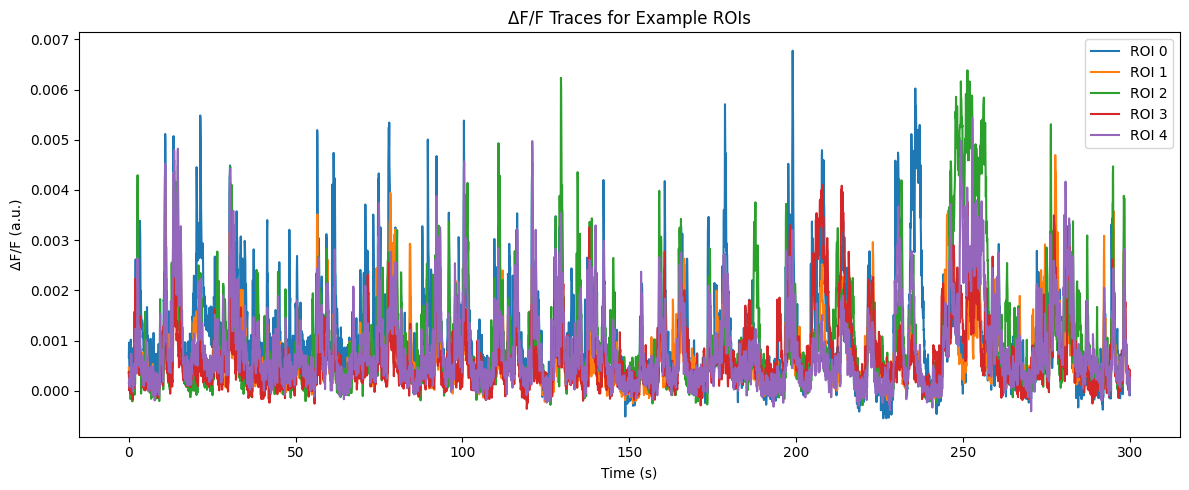

In [7]:
# Plot Dff and Fluorescence for a few ROIs
n_plot = 5  # Number of ROIs to visualize
roi_inds = np.arange(n_plot)

plt.figure(figsize=(12, 5))
for i in roi_inds:
    plt.plot(t, dff.data[:, i], label=f"ROI {i}")
plt.xlabel("Time (s)")
plt.ylabel("ΔF/F (a.u.)")
plt.title("ΔF/F Traces for Example ROIs")
plt.legend()
plt.tight_layout()
plt.show()

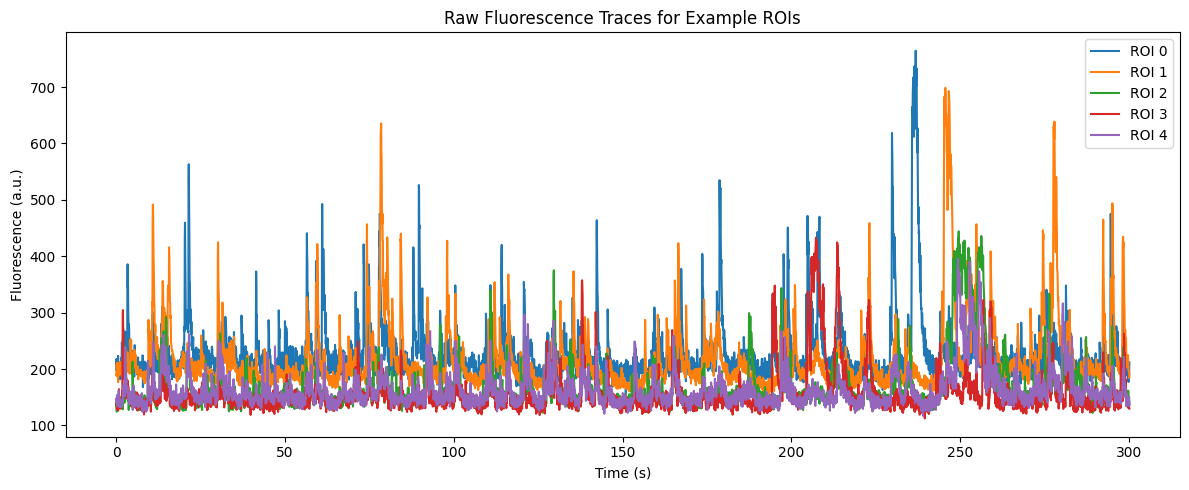

In [8]:
plt.figure(figsize=(12, 5))
for i in roi_inds:
    plt.plot(t, fluorescence.data[:, i], label=f"ROI {i}")
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence (a.u.)")
plt.title("Raw Fluorescence Traces for Example ROIs")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Summary Statistics: ROI Traces

It can be useful to look at the distribution of values across all ROIs, or visualize the mean and standard deviation of activity.

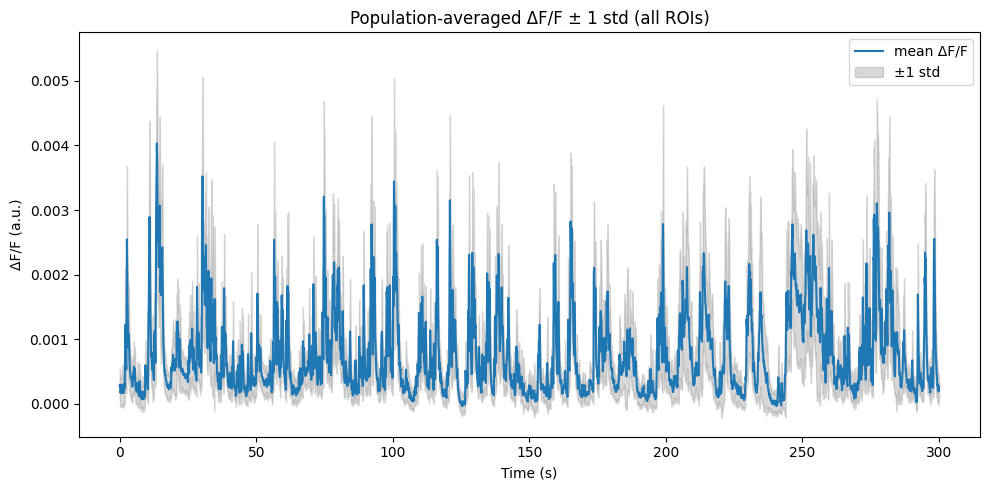

In [9]:
# Compute mean and standard deviation across ROIs for ΔF/F
dff_mean = np.mean(dff.data, axis=1)
dff_std = np.std(dff.data, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(t, dff_mean, label='mean ΔF/F')
plt.fill_between(t, dff_mean - dff_std, dff_mean + dff_std, color='gray', alpha=0.3, label='±1 std')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F (a.u.)')
plt.title('Population-averaged ΔF/F ± 1 std (all ROIs)')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Explore Segmentation and Overlay ROI Masks

Each ROI corresponds to a spatial segmentation ("pixel mask") in the field of view, available as a table in the NWB file.
We'll visualize the binary masks for a few ROIs.

Segmentation DataFrame head:
                                           pixel_mask
id                                                   
7   [[195, 233, 0.8797294], [196, 233, 1.1540956],...
8   [[13, 267, 0.98032975], [14, 267, 0.5083171], ...
9   [[322, 68, 0.70999473], [323, 68, 1.1739655], ...
11  [[420, 338, 1.185967], [421, 338, 2.0150337], ...
12  [[191, 139, 1.0358119], [192, 139, 1.2613564],...


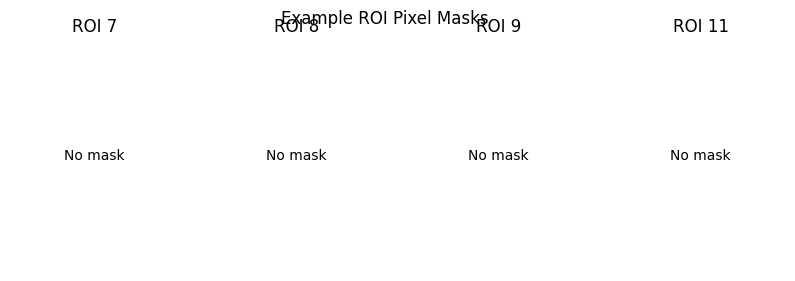

In [10]:
# Convert segmentation table to pandas DataFrame and display mask for some ROIs
plane_seg = data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation_1']
df_masks = plane_seg.to_dataframe()  # DataFrame with 'pixel_mask'

print("Segmentation DataFrame head:")
print(df_masks.head())

# Plot binary pixel masks for a few ROIs
# Each pixel_mask is a list of [x, y, weight], not a NumPy array.
n_masks_to_show = min(4, len(df_masks))
plt.figure(figsize=(10, 3))
for i, roi_idx in enumerate(df_masks.index[:n_masks_to_show]):
    plt.subplot(1, n_masks_to_show, i + 1)
    pixmask = df_masks.loc[roi_idx, 'pixel_mask']
    pixmask = np.array(pixmask)  # Convert list of lists to numpy array
    if pixmask.ndim == 2 and pixmask.shape[1] >= 3:
        xi = pixmask[:, 0].astype(int)
        yi = pixmask[:, 1].astype(int)
        values = pixmask[:, 2]
        mask_img = np.zeros((np.max(yi)+1, np.max(xi)+1))
        mask_img[yi, xi] = values
        plt.imshow(mask_img, cmap='hot', origin='lower', aspect='auto')
    else:
        plt.text(0.5, 0.5, 'No mask', ha='center', va='center')
    plt.title(f'ROI {roi_idx}')
    plt.axis('off')
plt.suptitle('Example ROI Pixel Masks')
plt.show()

## 7. Next Steps and Further Analysis

This notebook provides a foundation for exploring Dandiset 001349:

- Streaming NWB neural imaging data from the DANDI archive.
- Visualizing ΔF/F and fluorescence traces for ROIs.
- Inspecting ROI segmentation masks.

For more advanced analyses (e.g., cell-cell correlation, activity event detection, behavioral alignment), researchers are encouraged to consult the Dandiset documentation and adapt this notebook.

Please note: All code herein leverages only functionality and dataset structure described above. For in-depth feature extraction, consider reading the NWB documentation and the associated metadata in the Dandiset.

[Dandiset 001349 on DANDI Archive](https://dandiarchive.org/dandiset/001349/0.250520.1729)